Epoch [1/50], Train Loss: 0.6120, Validation Loss: 0.6193, Accuracy: 86.06%
Epoch [2/50], Train Loss: 0.2362, Validation Loss: 0.2965, Accuracy: 90.30%
Epoch [3/50], Train Loss: 0.1594, Validation Loss: 0.4305, Accuracy: 89.09%
Epoch [4/50], Train Loss: 0.0875, Validation Loss: 0.4518, Accuracy: 89.09%
Epoch [5/50], Train Loss: 0.0651, Validation Loss: 0.4352, Accuracy: 89.70%
Epoch [6/50], Train Loss: 0.0246, Validation Loss: 0.3605, Accuracy: 91.52%
Epoch [7/50], Train Loss: 0.0293, Validation Loss: 0.3983, Accuracy: 92.12%
Epoch [8/50], Train Loss: 0.0157, Validation Loss: 0.2699, Accuracy: 92.12%
Epoch [9/50], Train Loss: 0.0090, Validation Loss: 0.3203, Accuracy: 93.33%
Epoch [10/50], Train Loss: 0.0048, Validation Loss: 0.3649, Accuracy: 92.73%
Epoch [11/50], Train Loss: 0.0163, Validation Loss: 0.3264, Accuracy: 93.33%
Epoch [12/50], Train Loss: 0.0190, Validation Loss: 0.5846, Accuracy: 89.70%
Epoch [13/50], Train Loss: 0.0091, Validation Loss: 0.5567, Accuracy: 90.91%
Epoch [1

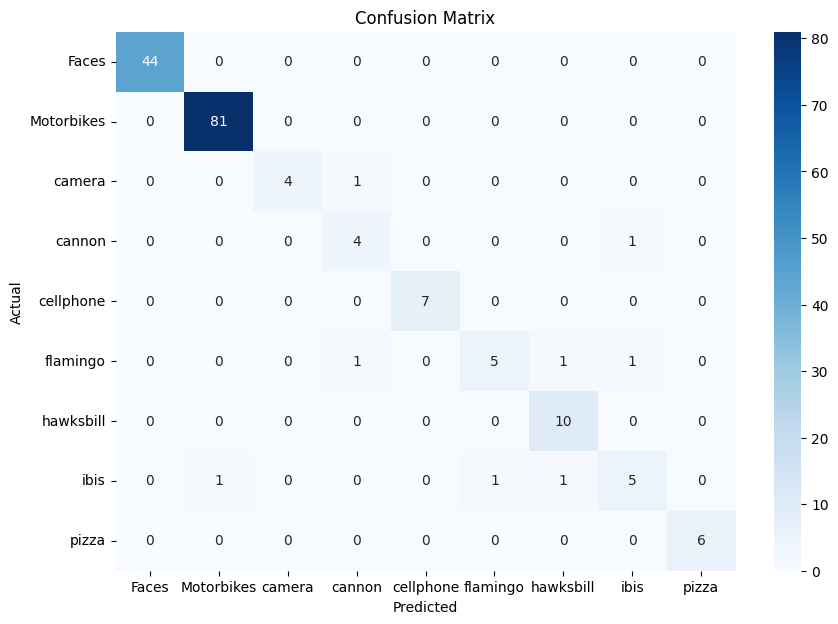

Accuracy: 95.40%
F1 Score: 0.9524
AUC Score: 0.9938


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
import numpy as np

# Logish Activation Function
class Logish(nn.Module):
    def __init__(self):
        super(Logish, self).__init__()

    def forward(self, x):
        return x * torch.log(1 + torch.sigmoid(x))

# CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            Logish(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            Logish(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            Logish(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            Logish(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Paths
train_path = "/content/CaltechTinySplit/train"
val_path = "/content/CaltechTinySplit/val"
test_path = "/content/CaltechTinySplit/test"

# Transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Datasets and Dataloaders
train_dataset = ImageFolder(root=train_path, transform=transform)
val_dataset = ImageFolder(root=val_path, transform=transform)
test_dataset = ImageFolder(root=test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = CNNModel(num_classes=len(train_dataset.classes)).to(device)

# Optimizer, Loss Function, and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.3)
criterion = nn.CrossEntropyLoss()

# Training and Validation Function
def train_and_validate(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {accuracy:.2f}%")

# Training the model
epochs = 50
train_and_validate(model, train_loader, val_loader, epochs)

# Test Function with Enhanced Visualization
def test_model_with_visualization(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Softmax skorları için
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    # AUC Score Calculation
    auc = roc_auc_score(y_true, np.array(y_scores), multi_class="ovr")

    # Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

# Model Evaluation with Visualization
test_model_with_visualization(model, test_loader)